In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import wmfdata as wmf

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [2]:
%matplotlib inline
# Customize Matplotlib styles
mpl.rcParams["font.size"] = 15
mpl.rcParams["figure.figsize"] = (16, 10)

In [3]:
# CHANGE THIS FOR A NEW MONTH!
# The time range for which to update. START is included, END is excluded.
START = "201809"
END = "201810"

# Create table if necessary

In [4]:
wmf.mariadb.run("""
CREATE TABLE IF NOT EXISTS staging.editor_month (
  `wiki` varbinary(255) NOT NULL,
  `month` date NOT NULL,
  `local_user_id` int(10) unsigned NOT NULL,
  `user_name` varbinary(255) NOT NULL DEFAULT '',
  `edits` int(10) unsigned NOT NULL DEFAULT '0',
  `content_edits` int(10) unsigned NOT NULL DEFAULT '0',
  `deleted_edits` int(10) unsigned NOT NULL DEFAULT '0',
  `mobile_web_edits` int(10) unsigned NOT NULL DEFAULT '0',
  `mobile_app_edits` int(10) unsigned NOT NULL DEFAULT '0',
  `visual_edits` int(10) unsigned NOT NULL DEFAULT '0',
  `ve_source_edits` int(10) unsigned NOT NULL DEFAULT '0',
  `bot_flag` tinyint(1) NOT NULL DEFAULT '0',
  `user_registration` datetime DEFAULT NULL,
  PRIMARY KEY (`wiki`,`month`,`local_user_id`),
  KEY `wiki_user` (`wiki`,`user_name`),
  KEY `user_name` (`user_name`),
  KEY `month_wiki` (`month`,`wiki`)
) 
ENGINE=InnoDB
DEFAULT CHARSET=binary
COMMENT='See documentation at https://meta.wikimedia.org/wiki/Research:Editor_month_dataset' 
""")

# Update table

In [5]:
with open("queries/update_editor_month.sql") as f:
    update_query = f.read()

isolate_cmd = "set session transaction isolation level read uncommitted;"
update_query = update_query.format(start=START, end=END)

wmf.mariadb.multirun([isolate_cmd, update_query])

aawiki completed in 0 s
aawikibooks completed in 0 s
aawiktionary completed in 0 s
abwiki completed in 1 s
abwiktionary completed in 0 s
acewiki completed in 1 s
adywiki completed in 0 s
afwiki completed in 6 s
afwikibooks completed in 0 s
afwikiquote completed in 0 s
afwiktionary completed in 0 s
akwiki completed in 0 s
akwikibooks completed in 0 s
akwiktionary completed in 0 s
alswiki completed in 1 s
alswikibooks completed in 1 s
alswikiquote completed in 1 s
alswiktionary completed in 1 s
amwiki completed in 4 s
amwikiquote completed in 0 s
amwiktionary completed in 0 s
angwiki completed in 0 s
angwikibooks completed in 0 s
angwikiquote completed in 0 s
angwikisource completed in 0 s
angwiktionary completed in 0 s
anwiki completed in 1 s
anwiktionary completed in 0 s
arcwiki completed in 0 s
arwiki completed in 216 s
arwikibooks completed in 0 s
arwikinews completed in 1 s
arwikiquote completed in 0 s
arwikisource completed in 1 s
arwikiversity completed in 0 s
arwiktionary complet

# Quality checks

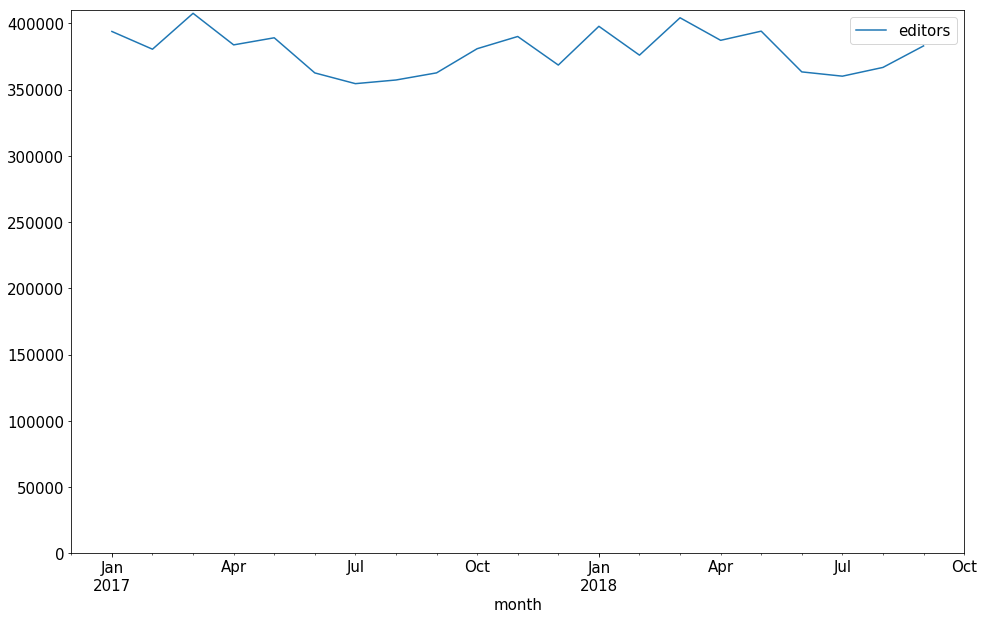

In [6]:
eds = wmf.mariadb.run("""
    select month, count(*) as editors
    from staging.editor_month 
    where month >= "2017-01-01"
    group by month
""")

eds["month"] = eds["month"].apply(pd.to_datetime)
eds = eds.set_index("month")
eds.plot(ylim=0);

In [7]:
eds.tail()

,editors
month,
2018-05-01,394032
2018-06-01,363298
2018-07-01,360069
2018-08-01,366679
2018-09-01,382912


In [8]:
v_active = wmf.mariadb.run("""
    select month, count(*) as very_active_editors
    from staging.editor_month 
    where month >= "2017-01-01" and content_edits >= 100
    group by month
""")

v_active["month"] = v_active["month"].apply(pd.to_datetime)
v_active = v_active.set_index("month")

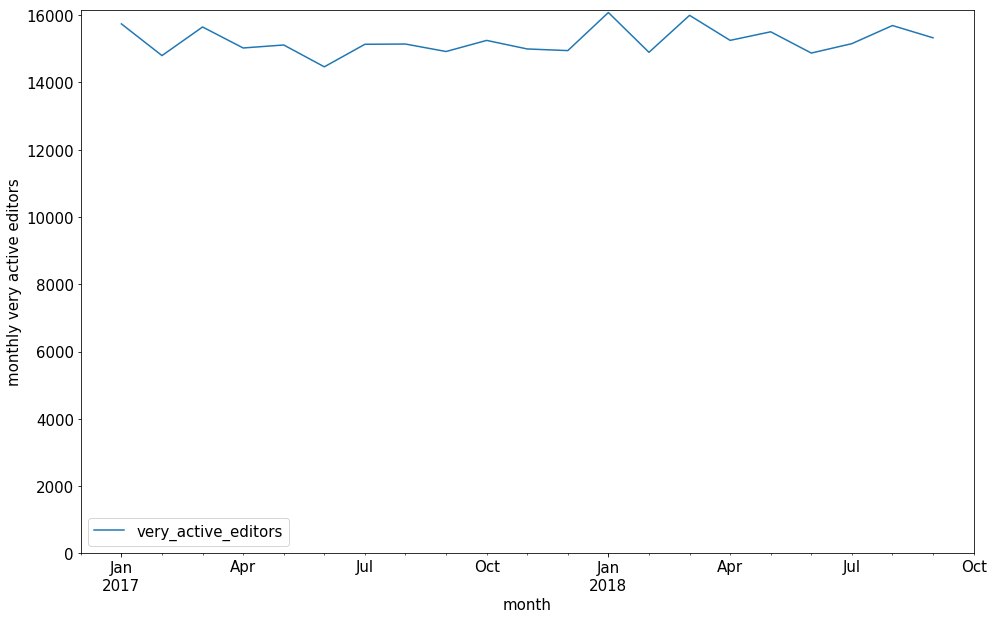

In [9]:
v_active.plot(ylim=0)
plt.ylabel("monthly very active editors");

In [10]:
v_active.tail()

,very_active_editors
month,
2018-05-01,15503
2018-06-01,14871
2018-07-01,15151
2018-08-01,15689
2018-09-01,15324


In [11]:
wikis = wmf.mariadb.run("""
    select month, wiki, count(*) 
    from staging.editor_month 
    where month >= "2017-11-01" and wiki in ("arwiki", "dewiki", "enwiki", "kowiki", "zhwiki")
    group by wiki, month
""")

wikis["month"] = wikis["month"].apply(pd.to_datetime)
wikis = wikis.set_index("month")
wikis = wikis.pivot(columns="wiki")
wikis.columns = wikis.columns.droplevel(0)

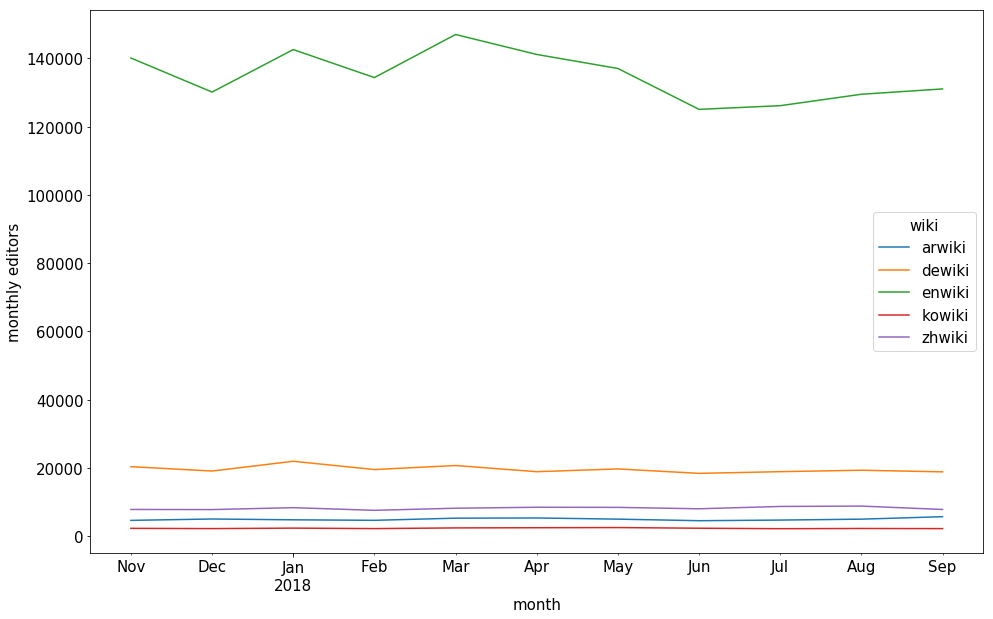

In [12]:
wikis.plot()
plt.ylabel("monthly editors");